In [55]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [56]:
import os, sys

import torch
from torch import nn
import torch.nn.utils.prune as prune
import torch.nn.functional as F

import yaml
import scipy
import numpy as np
import pandas as pd

proj_root = os.path.dirname(os.path.dirname(os.path.abspath(".")))
sys.path.append(proj_root)

from minatar import Environment

from minatar_dqn.my_dqn import Conv_QNET, build_environment
from minatar_dqn.redo import apply_redo_parametrization

import matplotlib.pyplot as plt
import seaborn as sns 
sns.set()

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

from experiments.experiment_utils import (
    seed_everything,
    search_files_containing_string,
    split_path_at_substring,
    collect_training_output_files,
)

For each checkpoint of an experiment we want to prune with different pruning factors and compare against different thresholds + redo scores

In [57]:
# Collect all paths to models in a specified folder
file_dir = os.path.dirname(os.path.abspath("."))
training_outputs_folder_path = os.path.join(proj_root, "experiments", "training", "outputs")
pruning_outputs_folder_path = os.path.join(file_dir, "outputs")
training_timestamp_folder = "2023_05_22-08_44_19"

experiments_folder = os.path.join(training_outputs_folder_path, training_timestamp_folder)

experiment_paths = collect_training_output_files(
        os.path.join(training_outputs_folder_path, training_timestamp_folder)
    )

for exp in experiment_paths:
    exp["models_folder_path"] = os.path.dirname(exp["model_path"])


In [58]:
experiment_paths[0]

{'model_path': 'd:\\Work\\PhD\\minatar_work\\experiments\\training\\outputs\\2023_05_22-08_44_19\\conv16_lin64\\asterix\\0\\model_checkpoints\\mck_25',
 'training_folder_path': 'd:\\Work\\PhD\\minatar_work\\experiments\\training\\outputs\\2023_05_22-08_44_19\\conv16_lin64\\asterix\\0',
 'config_path': 'd:\\Work\\PhD\\minatar_work\\experiments\\training\\outputs\\2023_05_22-08_44_19\\conv16_lin64\\asterix\\0\\conv16_lin64_asterix_0_config',
 'stats_path': 'd:\\Work\\PhD\\minatar_work\\experiments\\training\\outputs\\2023_05_22-08_44_19\\conv16_lin64\\asterix\\0\\conv16_lin64_asterix_0_train_stats',
 'models_folder_path': 'd:\\Work\\PhD\\minatar_work\\experiments\\training\\outputs\\2023_05_22-08_44_19\\conv16_lin64\\asterix\\0\\model_checkpoints'}

In [59]:
with open(experiment_paths[0]["config_path"], "r") as ymlfile:
    cfg = yaml.safe_load(ymlfile)

cfg

{'agent_params': {'agent': 'AgentDQN',
  'args_': {'batch_size': 32,
   'epsilon': {'decay': 250000, 'end': 0.01, 'start': 1.0},
   'gamma': 0.99,
   'loss_fcn': 'mse_loss',
   'replay_start_size': 5000,
   'target_model_update_freq': 100,
   'train_step_cnt': 200000,
   'training_freq': 4,
   'validation_enabled': True,
   'validation_epsilon': 0.001,
   'validation_step_cnt': 125000}},
 'environment': 'asterix',
 'epochs_to_train': 25,
 'estimator': {'args_': {'conv_hidden_out_size': 16,
   'lin_hidden_out_size': 64},
  'model': 'Conv_QNET'},
 'experiment_name': 'conv16_lin64_asterix_0',
 'experiment_output_folder': 'd:\\Work\\PhD\\minatar_work\\experiments\\training\\outputs\\2023_05_22-08_44_19\\conv16_lin64\\asterix\\0',
 'experiment_start_timestamp': '2023_05_22-08_44_19',
 'optim': {'args_': {'eps': 0.00015, 'lr': 6.25e-05}, 'name': 'Adam'},
 'path_experiments_outputs': 'd:\\Work\\PhD\\minatar_work\\experiments\\training\\outputs',
 'redo': {'beta': 0.1, 'enabled': True, 'tau': 

In [60]:
def mask_to_score_distance(mask, scores):
    num_ones = np.count_nonzero(mask)

    if num_ones == 0:
        return 0
    
    # Sort the scores in ascending order and get their corresponding indices
    sorted_indices = np.argsort(scores)
    
    # Create a new mask where the N smallest values represent True
    new_mask = torch.zeros_like(mask, dtype=torch.bool)
    new_mask[sorted_indices[:num_ones]] = True
     
    # Calculate the Hamming distance between the masks
    hamming_distance = torch.sum(torch.logical_and(torch.eq(mask, True), torch.eq(new_mask, False)))
    hamming_relative_distance = hamming_distance.item() / num_ones

    return hamming_relative_distance

def compare_redo_pruning(exp_paths):

    training_stats_data = torch.load(exp_paths["stats_path"])
    redo_scores = training_stats_data["redo_scores"]["policy"]

    checkpoints_paths = search_files_containing_string(
        exp_paths["models_folder_path"], "mck", substring_location="containing"
    )

    # read the config so that the model architecture can be loaded
    with open(exp_paths["config_path"], "r") as ymlfile:
        cfg = yaml.safe_load(ymlfile)

    results = []
    for checkpoint_path in checkpoints_paths:
        
        # Build a new model
        validation_env = build_environment(
            cfg["environment"], cfg["seed"]
        )

        # returns state as [w, h, channels]
        state_shape = validation_env.observation_space.shape

        # permute to get batch, channel, w, h shape
        # specific to minatar
        in_features = (state_shape[2], state_shape[0], state_shape[1])
        in_channels = in_features[0]
        num_actions = validation_env.action_space.n

        checkpoint_model = Conv_QNET(in_features = in_features, 
                                    in_channels = in_channels, 
                                    num_actions = num_actions, 
                                    **cfg["estimator"]["args_"])
        checkpoint_model = apply_redo_parametrization(checkpoint_model, tau=0.1)

        # Get the state of the model
        checkpoint_models_state = torch.load(checkpoint_path)
        checkpoint_model.load_state_dict(checkpoint_models_state["policy_model_state_dict"])
        model_state = checkpoint_model.state_dict()

        # Compute kendall rank correlation coefficient for each layer
        layer_weight_keys = ["features.0.weight", "features.2.weight", "fc.0.weight"]
        for i, layer_key in enumerate(layer_weight_keys):
            weights = model_state[layer_key]

            # compute the weight of the neurons in this layer
            if weights.dim() > 2:
                l1_norms = torch.sum(torch.abs(weights), dim=(1, 2, 3))
            else:
                l1_norms = torch.sum(torch.abs(weights), dim=(1))

            neuron_rankings = torch.argsort(l1_norms)

            check_index = int(os.path.basename(checkpoint_path).split("_")[1]) - 1 # get the index of the checkpoint
            
            redo_score = redo_scores[check_index][i]
            redo_rankings = torch.argsort(redo_score)

            k_corr, k_pval = scipy.stats.kendalltau(neuron_rankings, redo_rankings)
            s_corr, s_pval = scipy.stats.spearmanr(neuron_rankings, redo_rankings)
            p_corr, p_pval = scipy.stats.pearsonr(l1_norms, redo_score)

            # also do an experiment with thresholding  

            tau_vals = [0.025, 0.1]

            for tau in tau_vals:
                dormant_neurons_mask = (redo_score <= tau)
                
                dormant_neurons_idx = dormant_neurons_mask.nonzero().flatten()

                new_row = {"seed": cfg["seed"],
                        "env": cfg["environment"],
                        "experiment": "_".join(cfg["experiment_name"].split("_")[:2]), # WARNING
                        "tau": tau,
                        "dead_neuron_l1norms": l1_norms[dormant_neurons_idx],
                        "dead_neuron_l1norms_avg": np.average(l1_norms[dormant_neurons_idx]),
                        "dead_neuron_ratio": len(dormant_neurons_idx) / len(redo_score),
                        "redo_l1norm_hamming": mask_to_score_distance(dormant_neurons_mask, l1_norms),
                        "checkpoint": os.path.basename(checkpoint_path),
                        "epoch": check_index, 
                        "layer": layer_key,
                        "kendall_r_corr": k_corr, 
                        "kendall_r_pval": k_pval,
                        "spearman_r_corr": s_corr, 
                        "spearman_r_pval": s_pval,
                        "pearson_corr": p_corr, 
                        "pearson_pval": p_pval
                        }
                results.append(new_row)

    df = pd.DataFrame(results)

    return df 
    

In [61]:
exp_analysis_results = []

for exp_paths in experiment_paths:
    exp_analysis_results.append(compare_redo_pruning(exp_paths))

# concatenate the dataframes vertically
df_res = pd.concat(exp_analysis_results)
df_res

c:\Users\Chainsword\anaconda3\envs\general\lib\site-packages\gym\envs\registration.py:555: UserWarning: WARN: The environment MinAtar/Asterix-v0 is out of date. You should consider upgrading to version `v1`.
  logger.warn(
c:\Users\Chainsword\anaconda3\envs\general\lib\site-packages\gym\utils\passive_env_checker.py:20: UserWarning: WARN: It seems a Box observation space is an image but the `dtype` is not `np.uint8`, actual type: bool. If the Box observation space is not an image, we recommend flattening the observation to have only a 1D vector.
  logger.warn(
c:\Users\Chainsword\anaconda3\envs\general\lib\site-packages\gym\utils\passive_env_checker.py:25: UserWarning: WARN: It seems a Box observation space is an image but the upper and lower bounds are not in [0, 255]. Generally, CNN policies assume observations are within that range, so you may encounter an issue if the observation values are not.
  logger.warn(
c:\Users\Chainsword\anaconda3\envs\general\lib\site-packages\gym\envs\reg

,seed,env,experiment,tau,dead_neuron_l1norms,dead_neuron_l1norms_avg,dead_neuron_ratio,redo_l1norm_hamming,checkpoint,epoch,layer,kendall_r_corr,kendall_r_pval,spearman_r_corr,spearman_r_pval,pearson_corr,pearson_pval
0,0,asterix,conv16_lin64,0.025,"[tensor(3.3978), tensor(2.9052), tensor(3.8876...",3.711692,0.43750,0.428571,mck_1,0,features.0.weight,0.083333,0.690095,0.082353,0.761733,0.473772,6.376420e-02
1,0,asterix,conv16_lin64,0.100,"[tensor(3.3978), tensor(2.9052), tensor(3.6997...",3.808709,0.75000,0.166667,mck_1,0,features.0.weight,0.083333,0.690095,0.082353,0.761733,0.473772,6.376420e-02
2,0,asterix,conv16_lin64,0.025,"[tensor(7.4492), tensor(8.2096), tensor(6.0271...",6.731621,0.25000,0.500000,mck_1,0,features.2.weight,0.650000,0.000215,0.835294,0.000056,0.286141,2.826493e-01
3,0,asterix,conv16_lin64,0.100,"[tensor(8.8033), tensor(8.1095), tensor(7.4492...",7.831610,0.68750,0.272727,mck_1,0,features.2.weight,0.650000,0.000215,0.835294,0.000056,0.286141,2.826493e-01
4,0,asterix,conv16_lin64,0.025,"[tensor(12.2215), tensor(12.0013), tensor(12.1...",12.138257,0.71875,0.021739,mck_1,0,fc.0.weight,-0.094246,0.270989,-0.117628,0.354603,0.942497,3.299078e-31
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145,1,space_invaders,conv8_lin32,0.100,"[tensor(8.6357), tensor(7.8074), tensor(7.6687)]",8.037274,0.37500,0.333333,mck_9,8,features.0.weight,0.214286,0.548413,0.357143,0.385121,0.751124,3.170254e-02
146,1,space_invaders,conv8_lin32,0.025,[tensor(10.5037)],10.503723,0.12500,1.000000,mck_9,8,features.2.weight,-0.642857,0.031151,-0.833333,0.010176,0.575495,1.355253e-01
147,1,space_invaders,conv8_lin32,0.100,"[tensor(9.0654), tensor(11.7338), tensor(10.50...",9.368734,0.62500,0.400000,mck_9,8,features.2.weight,-0.642857,0.031151,-0.833333,0.010176,0.575495,1.355253e-01
148,1,space_invaders,conv8_lin32,0.025,"[tensor(8.4035), tensor(30.2413), tensor(22.54...",15.201574,0.62500,0.150000,mck_9,8,fc.0.weight,-0.173387,0.169402,-0.261730,0.147889,0.644400,6.881498e-05


In [62]:
# big TODO
# Experiment 1: Set a threshold -> computed to select nr of dead neurons
# Compute pruning indexes. Compute huffman distance or simillar
# Do this as we advance through training

# Experiment 2: set a threshold
# Find the dead neurons and compute l1 norm of neurons
# plot the l1 norms through training

# use tau = 0.1 for finding dead neurons
# histogram of the l1 norm of dead neurons during training

In [63]:

mask = torch.tensor([False, True, False])
scores = [0, 1, 2]

mask_to_score_distance(mask, scores)

1.0

In [64]:

mask = torch.tensor([False, False, True])
scores = [0, 1, 2]

    
mask_to_score_distance(mask, scores)

1.0

In [65]:

mask = torch.tensor([True, False, False])
scores = [0, 1, 2]

    
mask_to_score_distance(mask, scores)

0.0

In [66]:

mask = torch.tensor([True, True, False])
scores = [0, 1, 2]

    
mask_to_score_distance(mask, scores)

0.0

In [67]:

mask = torch.tensor([False, True, True])
scores = [0, 1, 2]

    
mask_to_score_distance(mask, scores)

0.5

In [68]:
df_res.columns

Index(['seed', 'env', 'experiment', 'tau', 'dead_neuron_l1norms',
       'dead_neuron_l1norms_avg', 'dead_neuron_ratio', 'redo_l1norm_hamming',
       'checkpoint', 'epoch', 'layer', 'kendall_r_corr', 'kendall_r_pval',
       'spearman_r_corr', 'spearman_r_pval', 'pearson_corr', 'pearson_pval'],
      dtype='object')

Text(0.5, 0.98, 'dead_neuron_l1norms_avg')

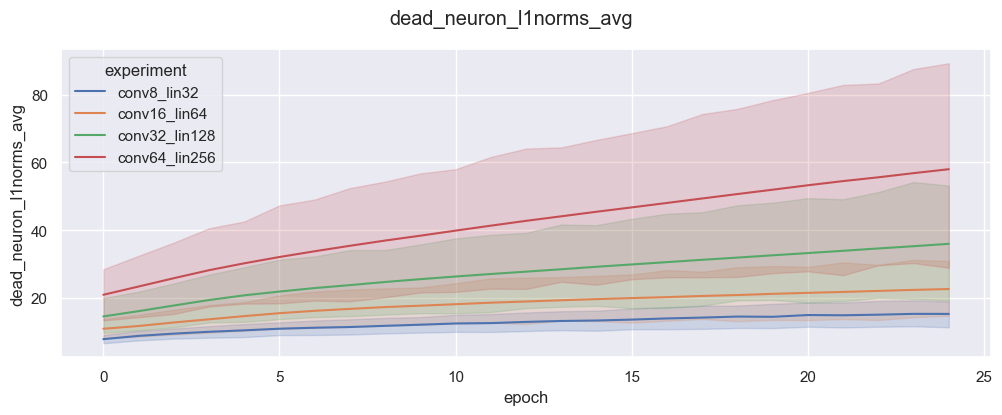

In [69]:
metric_col = 'dead_neuron_l1norms_avg'

experiment_order = ['conv8_lin32', 'conv16_lin64', 'conv32_lin128', 'conv64_lin256']

sub_df = df_res[df_res["tau"] == 0.1]

# Compute the average metric between the seeds for each experiment
avg_df = sub_df.groupby(['env', 'experiment', 'epoch', "layer"]).mean().reset_index()

fig, ax = plt.subplots(figsize=(12, 4))

sns.lineplot(avg_df, x="epoch", y=metric_col, hue='experiment', hue_order = experiment_order, ax = ax)

fig.suptitle(metric_col)

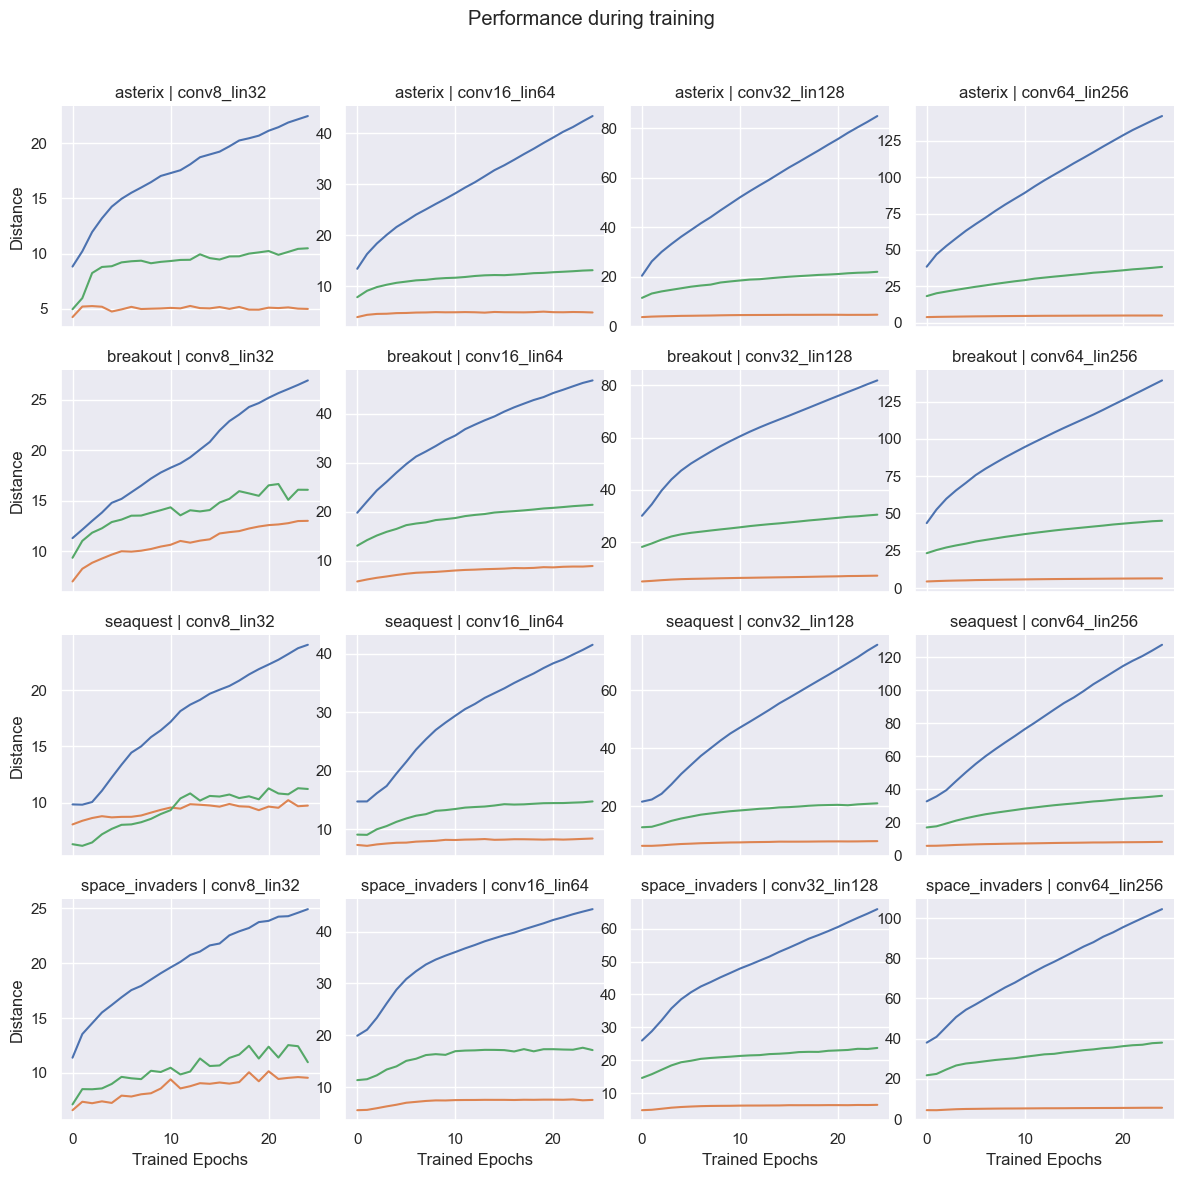

In [71]:
metric_col = 'dead_neuron_l1norms_avg'

experiment_order = ['conv8_lin32', 'conv16_lin64', 'conv32_lin128', 'conv64_lin256']

sub_df = df_res[df_res["tau"] == 0.1]

# Compute the average metric between the seeds for each experiment
avg_df = sub_df.groupby(['env', 'experiment', 'epoch', "layer"]).mean().reset_index()

g = sns.FacetGrid(avg_df, col_order=experiment_order, row='env', col='experiment', 
height = 3, hue="layer", aspect=1, sharey=False)
g.map(sns.lineplot, 'epoch', metric_col, ax=ax)

g.fig.suptitle('Performance during training')
g.set_titles(row_template='{row_name}', col_template='{col_name}', fontsize=1)

g.figure.subplots_adjust(top=0.9, wspace=0.1)
g.set_axis_labels('Trained Epochs', 'Distance')

# Show the plot
plt.show()

Text(0.5, 0.98, 'dead_neuron_ratio')

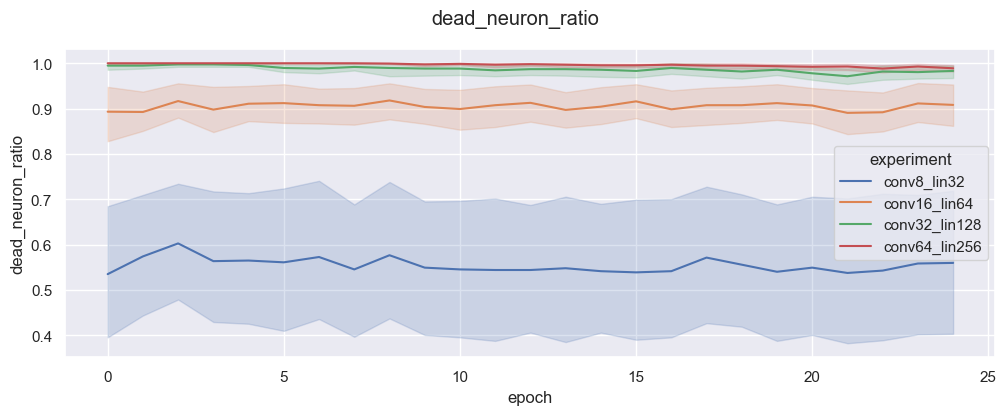

In [72]:
metric_col = 'dead_neuron_ratio'

experiment_order = ['conv8_lin32', 'conv16_lin64', 'conv32_lin128', 'conv64_lin256']

sub_df = df_res[df_res["tau"] == 0.1]

# Compute the average metric between the seeds for each experiment
avg_df = sub_df.groupby(['env', 'experiment', 'epoch', "layer"]).mean().reset_index()

fig, ax = plt.subplots(figsize=(12, 4))

sns.lineplot(avg_df, x="epoch", y=metric_col, hue='experiment', hue_order = experiment_order, ax = ax)

fig.suptitle(metric_col)

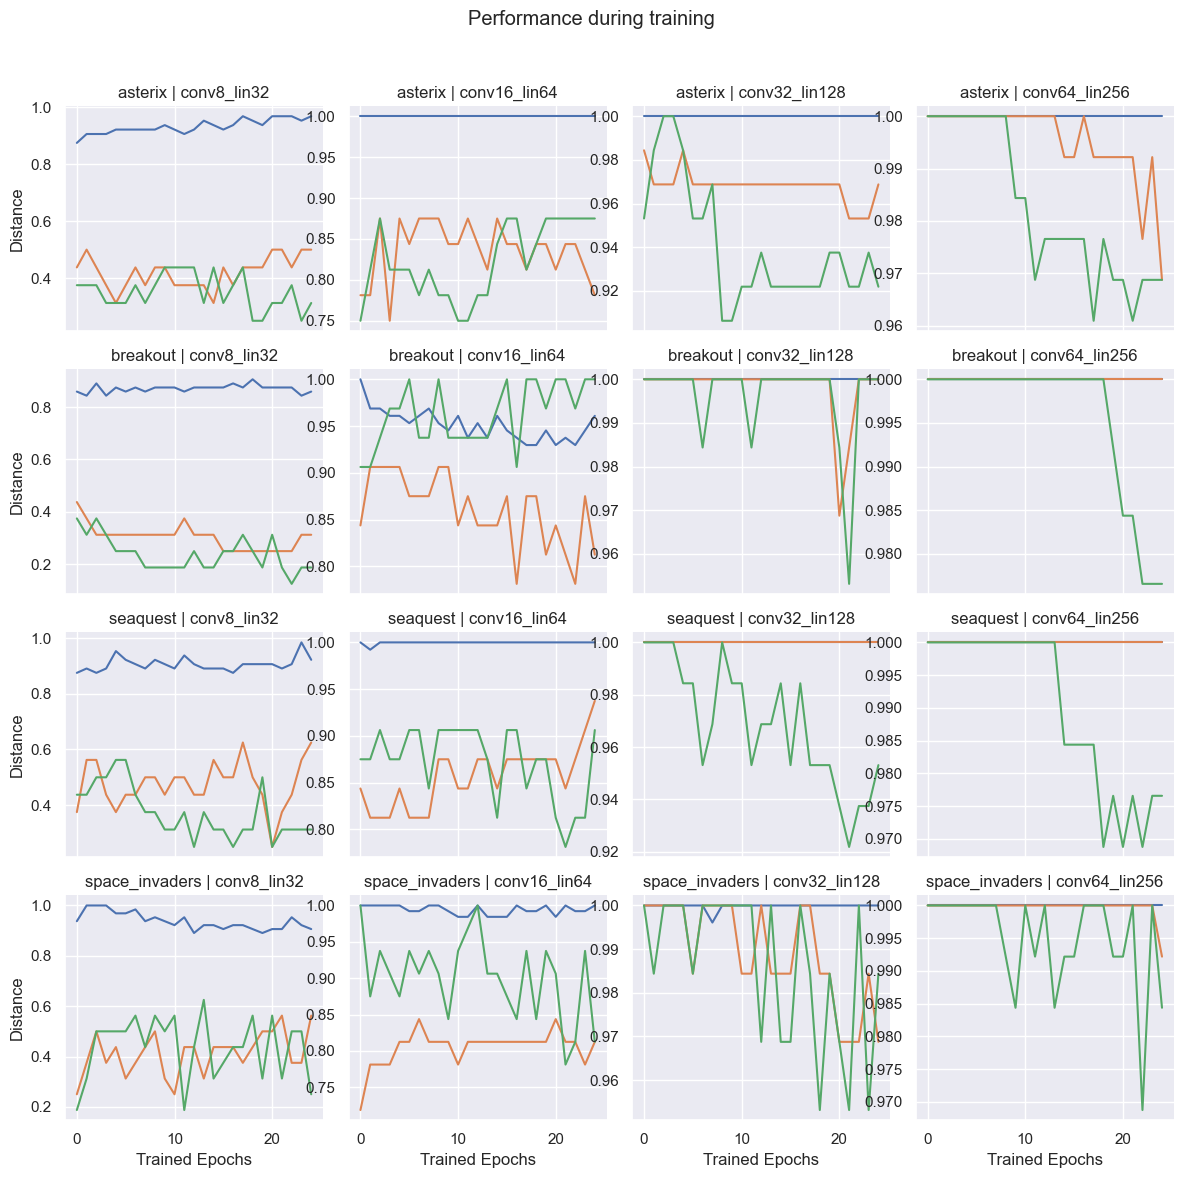

In [76]:
metric_col = 'dead_neuron_ratio'

experiment_order = ['conv8_lin32', 'conv16_lin64', 'conv32_lin128', 'conv64_lin256']

sub_df = df_res[df_res["tau"] == 0.1]

# Compute the average metric between the seeds for each experiment
avg_df = sub_df.groupby(['env', 'experiment', 'epoch', "layer"]).mean().reset_index()

g = sns.FacetGrid(avg_df, col_order=experiment_order, row='env', col='experiment', 
height = 3, hue="layer", aspect=1, sharey=False)
g.map(sns.lineplot, 'epoch', metric_col, ax=ax)

g.fig.suptitle('Performance during training')
g.set_titles(row_template='{row_name}', col_template='{col_name}', fontsize=1)

g.figure.subplots_adjust(top=0.9, wspace=0.1)
g.set_axis_labels('Trained Epochs', 'Distance')

# Show the plot
plt.show()

Text(0.5, 0.98, 'redo_l1norm_hamming')

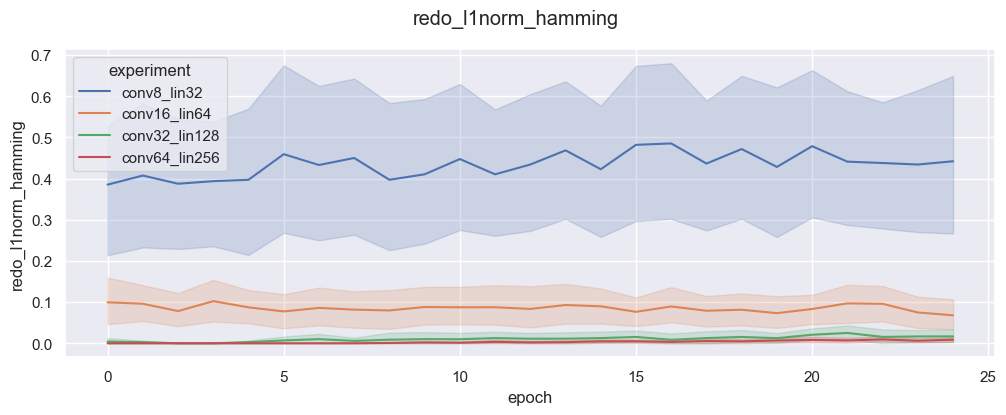

In [77]:
metric_col = 'redo_l1norm_hamming'

experiment_order = ['conv8_lin32', 'conv16_lin64', 'conv32_lin128', 'conv64_lin256']

sub_df = df_res[df_res["tau"] == 0.1]

# Compute the average metric between the seeds for each experiment
avg_df = sub_df.groupby(['env', 'experiment', 'epoch', "layer"]).mean().reset_index()

fig, ax = plt.subplots(figsize=(12, 4))

sns.lineplot(avg_df, x="epoch", y=metric_col, hue='experiment', hue_order = experiment_order, ax = ax)

fig.suptitle(metric_col)

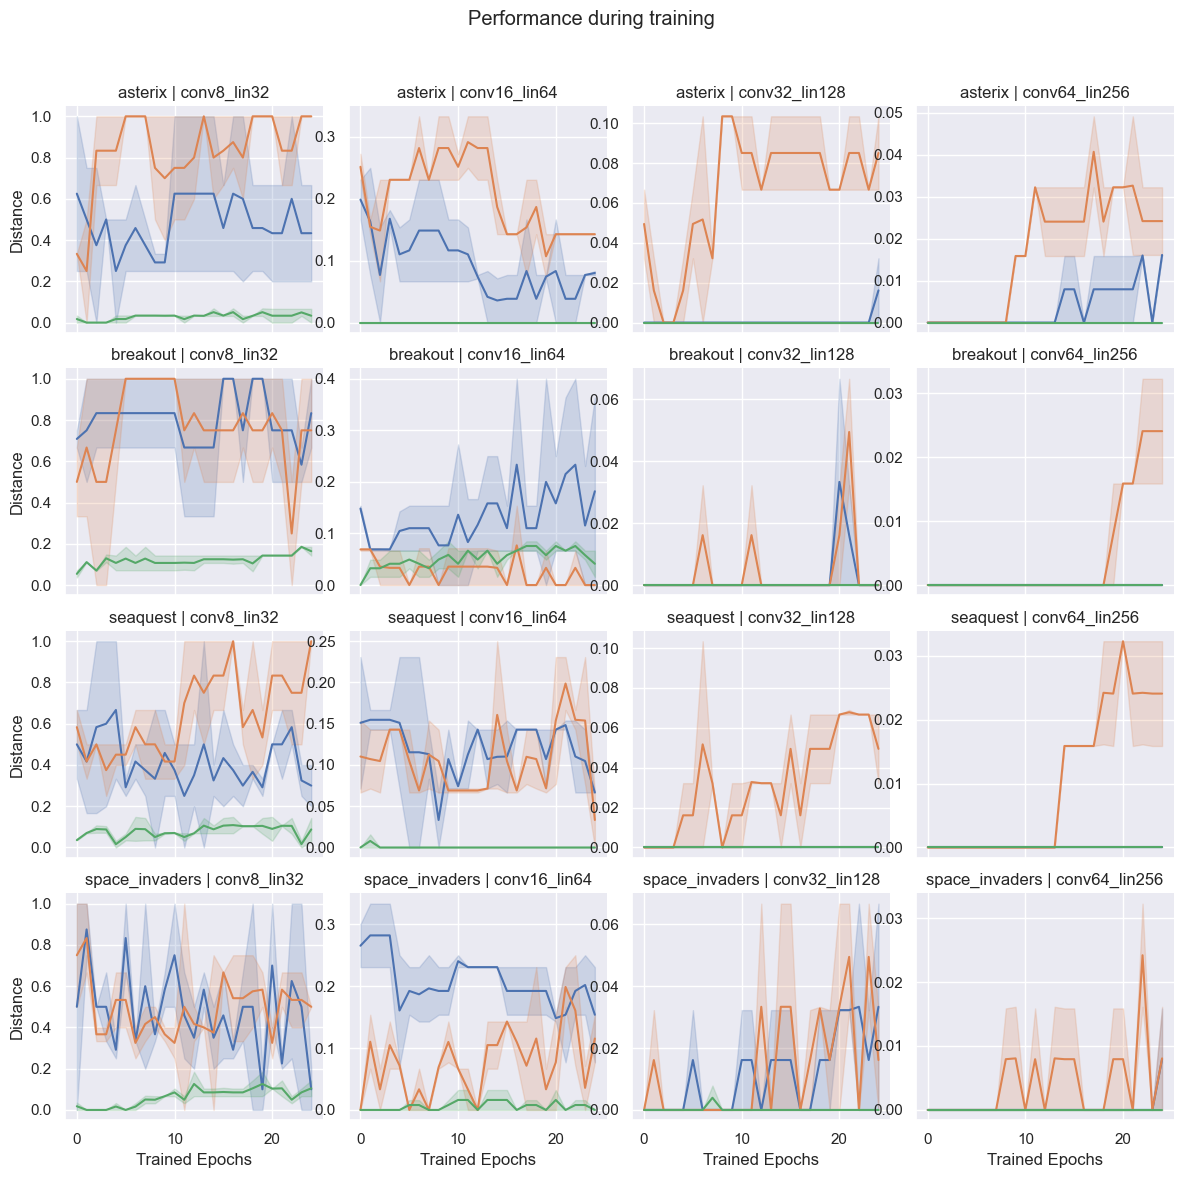

In [75]:
metric_col = 'redo_l1norm_hamming'

experiment_order = ['conv8_lin32', 'conv16_lin64', 'conv32_lin128', 'conv64_lin256']

sub_df = df_res[df_res["tau"] == 0.1]

# Compute the average metric between the seeds for each experiment
# avg_df = sub_df.groupby(['env', 'experiment', 'epoch', "layer"]).mean().reset_index()

g = sns.FacetGrid(sub_df, col_order=experiment_order, row='env', col='experiment', 
height = 3, hue="layer", aspect=1, sharey=False)
g.map(sns.lineplot, 'epoch', 'redo_l1norm_hamming')

g.fig.suptitle('Performance during training')
g.set_titles(row_template='{row_name}', col_template='{col_name}', fontsize=1)

g.figure.subplots_adjust(top=0.9, wspace=0.1)
g.set_axis_labels('Trained Epochs', 'Distance')

# Show the plot
plt.show()